In [ ]:
__author__ = 'A. Palaric, G. Desjonquères, V. Fernando Lopes De Souza, A. Fofana'
__date__ = '2022-01-25'
__version__ = '1.1.07'

# Implémentation des attaques sur un modèle

---


# Fonctionnement

## Ordres d'exécution :
La cellule 0 est à exécuter quoiqu'il arrive.
### Datasets :
**Si vous avez un dataset** : il vous suffit de modifier la cellule 1 pour importer votre dataset.
**Si vous n'en avez pas** : le dataset par défaut (MNIST) sera chargé en exécutant la cellule 1.
### Modèles :
**Si vous avez déjà un modèle Tensorflow** : il vous suffit de modifier le nom du fichier duquel importer le modèle dans la 2ème cellule de la section 3.

**Si vous n'en avez pas** : un modèle par défaut est déjà défini : *(conv, dense)*.Vous pouvez aussi en modifier la structure et en entraîner un autre en modifiant la cellule de la section 2, puis en exécutant cette cellule et la première cellule de la section 3.

### Attaques
Une fois le dataset et le modèle définis, vous pouvez exécuter les cellules correspondant aux attaques que vous souhaitez visualiser.

L'exécution de la section 5 vous permettra d'avoir un aperçu de l'effet des attaques sur les données en affichant un triplet d'image par attaque : l'image d'origine, l'image perturbée et la perturbation relative rajoutée.

---


In [ ]:
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.2 MB 4.9 MB/s 
     |████████████████████████████████| 3.3 MB 35.1 MB/s 
     |████████████████████████████████| 26.3 MB 1.7 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


## 0. Import des bibliothèques nécessaires

In [ ]:
from art.attacks.evasion import *
from art.estimators.classification import TensorFlowV2Classifier
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D
import tensorflow as tf
import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## 1. Définition des données

In [ ]:
####### Defining the dataset to train a MNIST model (fix for every attack) #######

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_test = x_test[0:100]
y_test = y_test[0:100]

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='test_accuracy')

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

11501568/11490434 [==============================] - 0s 0us/step
Accuracy on test data: 98.00%
(100, 28, 28, 1)


## 2. Définition des fonctions nécessaires pour entraîner un modèle Tensorflow

In [ ]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


epochs = 3


class KerasModel(Model):
    def __init__(self):
        super(KerasModel, self).__init__()
        self.conv1 = Conv2D(filters=3, kernel_size=3, activation='relu')
        self.flatten = Flatten()
        self.dense1 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x

## 3. Définition et entraînement du modèle

In [ ]:
# Creating and Training model
model = KerasModel()
for epoch in range(epochs):
    for images, labels in train_ds:
        train_step(images, labels)
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    template = 'Epoch {}, Loss: {:4.2f}, Accuracy: {:4.2f}, Test Loss: {:4.2f}, Test Accuracy: {:4.2f}'
    # print(template.format(epoch + 1,
    #                      train_loss.result(),
    #                      train_accuracy.result() * 100,
    #                      test_loss.result(),
    #                      test_accuracy.result() * 100))
y_test_pred = np.argmax(model(x_test), axis=1)
accuracy_test = np.sum(y_test_pred == y_test) / y_test.shape[0]
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(28, 28, 1), loss_object=loss_object,
                                    clip_values=(0, 1), channels_first=False)

model.save('attacks_model')  # Sauvegarde du modèle pour n'avoir à l'entraîner qu'une seule fois
print(x_test.shape)

In [ ]:
# Import du modèle et définition de celui-ci dans l'environnement de l'ART
model = tf.keras.models.load_model('attacks_model')
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(28, 28, 1), loss_object=loss_object,
                                    clip_values=(0, 1), channels_first=False)

x_test_adv_L = [] # Va contenir tous les datasets perturbés par toutes les attaques
Attacks = []  # Va contenir les noms des attaques

## 4. Implémentation des attaques

### 4.1. Wasserstein Attack

In [ ]:
intensity_wass = 0.5
attack_wass = Wasserstein(estimator=classifier, eps=intensity_wass, norm="inf")
x_test_adv_wass = attack_wass.generate(x_test)
np.save(f'x_test_adv_wass{intensity_wass}', x_test_adv_wass)

Wasserstein:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
x_test_adv_wass = np.load('x_test_adv_wass.npy')
x_test_adv_L.append(x_test_adv_wass)
if 'Wasserstein' not in Attacks:
  Attacks.append('Wasserstein')

### 4.2. Virtual Adversarial Attack

In [ ]:
intensity_va = 0.5
attack_va = VirtualAdversarialMethod(classifier=classifier, eps=intensity_va)
x_test_adv_va = attack_va.generate(x_test)
np.save(f'x_test_adv_va{intensity_va}', x_test_adv_va)

VAT:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
x_test_adv_va = np.load('x_test_adv_va.npy')
x_test_adv_L.append(x_test_adv_va)
if 'VirtualAdversary' not in Attacks:
  Attacks.append('VirtualAdversary')

### 4.3. Shadow Attack

In [ ]:
lambda_tv=0.3
attack_shdw = ShadowAttack(
    estimator=classifier, lambda_tv=lambda_tv, sigma=0.8)
x_test_adv_shdw = np.array([attack_shdw.generate(
    i.reshape((1, 28, 28, 1)))[0] for i in x_test])
np.save(f'x_test_adv_shdw{lambda_tv}', x_test_adv_shdw)

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

Shadow attack:   0%|          | 0/300 [00:00<?, ?it/s]

(100, 28, 28, 1)


In [ ]:
x_test_adv_shdw = np.load('x_test_adv_shdw.npy')
x_test_adv_L.append(x_test_adv_shdw)
if 'Shadow' not in Attacks:
  Attacks.append('Shadow')

### 4.4. NewtonFool Attack

NewtonFool:   0%|          | 0/100 [00:00<?, ?it/s]

Accuracy on adversarial test data: 4.00%
Average perturbation: 0.36


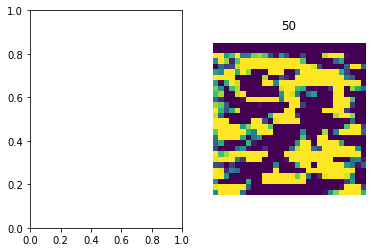

In [ ]:
intensity_nf = 0.85
attack_nf = NewtonFool(classifier=classifier, eta=intensity_nf)
x_test_adv_nf = attack_nf.generate(x_test)
x_test_adv_L.append(x_test_adv_nf)
if 'NewtonFool' not in Attacks:
  Attacks.append('NewtonFool')

### 4.5. FGSM Attack

In [ ]:
intensity_fgsm = 0.2
attack_fgsm = FastGradientMethod(estimator=classifier, eps=intensity_fgsm)
x_test_adv_fgsm = attack_fgsm.generate(x_test)
x_test_adv_L.append(x_test_adv_fgsm)
if 'FGSM' not in Attacks:
  Attacks.append('FGSM')

### 4.6. Carlini&Wagner Attack

In [ ]:
intensity_cw = 0.95
attack_cw = CarliniLInfMethod(
    classifier=classifier, eps=intensity_cw)
x_test_adv_cw = attack_cw.generate(x_test)
x_test_adv_L.append(x_test_adv_cw)
if 'C&W' not in Attacks:
  Attacks.append('C&W')

### 4.7. DeepFool Attack

In [ ]:
intensity_df = 1e-4
attack_df = DeepFool(classifier=classifier, epsilon=intensity_df)
x_test_adv_df, pertu = attack_df.generate(x_test)
x_test_adv_L.append(x_test_adv_df)
if 'DeepFool' not in Attacks:
  Attacks.append('DeepFool')

### 4.8. Iterative Frame Saliency Attack

In [ ]:
attack_ifs = FrameSaliencyAttack(
    classifier=classifier, attacker=attack_fgsm)
x_test_adv_ifs = attack_ifs.generate(x_test)
x_test_adv_L.append(x_test_adv_ifs)
if 'IterativeFrame' not in Attacks:
  Attacks.append('IterativeFrame')

### 4.9. Adversarial Patch

In [ ]:
# PARAMETRES

target_name = 2
batch_size = 128
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5.
max_iter = 15
image_shape=(28, 28, 1)

In [ ]:
# CREATION DE L'ADVERSARIAL PATCH
ap = AdversarialPatch(classifier=classifier, rotation_max=rotation_max, scale_min=scale_min, scale_max=scale_max,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size)

y_target = (y_train == target_name).astype(float)
patch, patch_mask = ap.generate(x=x_train, y=y_target)

In [ ]:
# VISUALISATION DU PATCH
np.shape(patch)
plt.matshow(patch.reshape(image_shape))
plt.clim(0, 1)

In [ ]:
# Génération des sets adversariaux
x_test_adv_patch = ap.apply_patch(x_test, scale=0.5)
x_test_adv_L.append(x_test_adv_patch)
if 'AdversarialPatch' not in Attacks:
  Attacks.append('AdversarialPatch')

### 4.10 Projected Gradient Descent

In [ ]:
intensity_pgd = 0.3
attack_pgd = AutoProjectedGradientDescent(estimator=classifier, eps=intensity_pgd)
x_test_adv_pgd = attack_pgd.generate(x_test)
x_test_adv_L.append(x_test_adv_pgd)
if 'PGD' not in Attacks:
  Attacks.append('PGD')

## 5. Visualisation de résultats

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=len(Attacks)+1)
for i in range(len(Attacks)):
    y_test_pred = np.argmax(model(x_test_adv_L[i]), axis=1)
    accuracy_test_adv = np.sum(
        y_test_pred == y_test[:len(y_test_pred)])/y_test_pred.shape[0]
    perturbation = np.mean(
        np.abs((x_test_adv_L[i]-x_test[:len(x_test_adv_L[i])]), dtype=np.double))
    print("\n"+Attacks[i]+" :")
    print('Accuracy on adversarial test data: {:4.2f}%'.format(
        accuracy_test_adv * 100))
    print('Average perturbation: {:4.2f}'.format(perturbation))
    ax[0, i+1].matshow(x_test_adv_L[i][0, :, :, 0]*255)
    ax[0, i+1].axis('off')
    ax[1, i+1].matshow((x_test_adv_L[i][0, :, :, 0] -
                        x_test[0, :, :, 0])*255)
    ax[1, i+1].axis('off')
    ax[0, i+1].set_title(Attacks[i])
ax[0, 0].matshow(x_test[0, :, :, 0]*255)
ax[0, 0].axis('off')
ax[1, 0].matshow(x_test[0, :, :, 0]-x_test[0, :, :, 0])
ax[1, 0].axis('off')
ax[1, 0].set_title('Relative Perturbation added')
ax[0, 0].set_title('Original')
plt.show()



# Useful Links:

ART - https://github.com/Trusted-AI/adversarial-robustness-toolbox

ART docs - https://adversarial-robustness-toolbox.readthedocs.io/en/latest/

ART attacks - https://github.com/Trusted-AI/adversarial-robustness-toolbox/wiki/ART-Attacks